## Initialisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from modules.loader import ImmothepDataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

loader = ImmothepDataLoader()

DATASET_PATH = '../datas/CURATED/'

%load_ext autoreload
%autoreload 2

loader.ensure_data_loaded()

## Chargement du fichier contenant les données concernant les appartements

extrait_df_valeurs_foncieres_Appartement = pd.read_csv(DATASET_PATH + "appartement_filtre.csv", sep=',', usecols=['Valeur fonciere', 'Surface reelle bati', 'Nombre pieces principales', 'Surface', 'Code postal'], encoding='utf-8')
extrait_df_valeurs_foncieres_Appartement.rename(columns={'Surface reelle bati': 'Surface terrain'}, inplace=True)

## Chargement du fichier contenant les données concernant les maisons

In [48]:
extrait_df_valeurs_foncieres_Maison = pd.read_csv(DATASET_PATH + "maison_filtre.csv", sep=',', usecols=['Valeur fonciere', 'Surface', 'Nombre pieces principales', 'Surface terrain', 'Code postal'], encoding='utf-8')


## Insertion des données

In [52]:
valeurFonciere = 20000
surfaceReelleBati = 0
surface = 648
nombrePiecesPrincipales = 11
surfaceTerrain = 5000
codePostal = 36230

if (surfaceReelleBati > 0):
    extrait_df_valeurs_foncieres_Appartement = extrait_df_valeurs_foncieres_Appartement.append({'Valeur fonciere' : valeurFonciere, 'Surface reelle bati' : surfaceReelleBati, 'Nombre pieces principales' : nombrePiecesPrincipales, 'Surface' : surface, 'Code postal' : codePostal} , ignore_index=True)

if (surfaceTerrain > 0):
    extrait_df_valeurs_foncieres_Maison = extrait_df_valeurs_foncieres_Maison.append({'Valeur fonciere' : valeurFonciere,'Nombre pieces principales' : nombrePiecesPrincipales, 'Surface terrain' : surfaceTerrain , 'Surface' : surface, 'Code postal' : codePostal} , ignore_index=True)

## Création du fichier csv contenant les villes

In [7]:
df_villes_france = pd.read_csv(DATASET_PATH + "villes_france.csv", sep=',', encoding='utf-8')
df_villes_france.to_csv(DATASET_PATH + "villes_france_titres.csv", header=['ville_id', 'ville_departement', 'ville_slug', 'ville_nom', 'ville_nom_simple', 'ville_nom_reel', 'ville_nom_soundex', 'ville_nom_metaphone', 'ville_code_postal', 'ville_commune', 'ville_code_commune', 'ville_arrondissement', 'ville_canton', 'ville_amdi', 'ville_population_2010', 'ville_population_1999', 'ville_population_2012', 'ville_densite_2010', 'ville_surface', 'ville_longitude_deg', 'ville_latitude_deg', 'ville_longitude_grd', 'ville_latitude_grd', 'ville_longitude_dms', 'ville_latitude_dms', 'ville_zmin', 'ville_zmax'], index=False)

df_villes_france_titres_vue = pd.read_csv(DATASET_PATH + "villes_france_titres.csv", sep=',', usecols=['ville_code_postal', 'ville_nom_reel', 'ville_population_2012', 'ville_surface'], encoding='utf-8')

df_villes_france_titres = pd.read_csv(DATASET_PATH + "villes_france_titres.csv", sep=',', usecols=['ville_code_postal', 'ville_nom_soundex', 'ville_population_2012', 'ville_surface'], encoding='utf-8')

## Filtrage des codes postaux en cas de valeurs multiples

In [8]:
df_villes_france_titres['code_postal'] = df_villes_france_titres['ville_code_postal'].str[:5]
df_villes_france_titres = df_villes_france_titres.drop('ville_code_postal', 1)

## Calcul de l'estimation de la valeur pour les appartements

In [17]:
df_villes_france_titres["code_postal"] = df_villes_france_titres["code_postal"].astype(float)
extrait_df_valeurs_foncieres_Appartement["Code postal"] = extrait_df_valeurs_foncieres_Appartement["Code postal"].astype(float)

df_Test = pd.merge(df_villes_france_titres, extrait_df_valeurs_foncieres_Appartement, left_on='code_postal', right_on='Code postal')
df_Donnees_appartement = df_Test.groupby('code_postal').mean()
df_Donnees_appartement['ville_surface'] = df_Donnees_appartement['ville_surface'] * 1000

print(df_Donnees_appartement['Surface terrain'].mean(axis=0) / df_Donnees_appartement['Surface'].mean(axis=0))

formuleTerrain =  (df_Donnees_appartement['Surface terrain'].mean(axis=0) / df_Donnees_appartement['Surface'].mean(axis=0)) - ((df_Donnees_appartement['Surface terrain'] / df_Donnees_appartement['Surface']))
formulePiece = 1 - (df_Donnees_appartement['Nombre pieces principales'] / df_Donnees_appartement['Nombre pieces principales'].mean(axis=0))
formuleSurface = 1 - (df_Donnees_appartement['ville_population_2012'] / df_Donnees_appartement['ville_surface'])

df_Donnees_appartement['formule_finale'] = formuleTerrain + formulePiece + formuleSurface

df_Donnees_appartement['valeur_estimee'] = df_Donnees_appartement['Valeur fonciere'] * (df_Donnees_appartement['formule_finale'] + 100) / 100

df_Donnees_appartement.head()

1.0077797093300689


,ville_population_2012,ville_surface,Valeur fonciere,Code postal,Surface terrain,Nombre pieces principales,Surface,formule_finale,valeur_estimee
code_postal,,,,,,,,,
1000.0,22700.000000,18220.000000,94150.337838,1000.0,53.945946,2.270270,53.454865,-0.181314,93979.630378
1090.0,1383.333333,6858.333333,138809.375000,1090.0,66.125000,2.750000,62.070000,0.609358,139655.221421
1120.0,2500.000000,13367.142857,133740.833333,1120.0,54.000000,2.500000,52.765833,0.768827,134769.069367
1150.0,1518.181818,14167.272727,114684.615385,1150.0,63.923077,2.692308,61.462308,0.752926,115548.105761
1170.0,2550.000000,15512.500000,198131.556962,1170.0,54.772152,2.430380,53.972785,0.828691,199773.455825


## Calcul de l'estimation de la valeur pour les maisons

In [10]:
df_villes_france_titres["code_postal"] = df_villes_france_titres["code_postal"].astype(float)
extrait_df_valeurs_foncieres_Maison["Code postal"] = extrait_df_valeurs_foncieres_Maison["Code postal"].astype(float)

df_Test = pd.merge(df_villes_france_titres, extrait_df_valeurs_foncieres_Maison, left_on='code_postal', right_on='Code postal')
df_Donnees_maison = df_Test.groupby('code_postal').mean()
df_Donnees_maison['ville_surface'] = df_Donnees_maison['ville_surface'] * 1000""

print(df_Donnees_maison['Surface terrain'].mean(axis=0) / df_Donnees_maison['Surface'].mean(axis=0))

formuleTerrain =  (df_Donnees_maison['Surface terrain'].mean(axis=0) / df_Donnees_maison['Surface'].mean(axis=0)) - ((df_Donnees_maison['Surface terrain'] / df_Donnees_maison['Surface']))
formulePiece = 1 - (df_Donnees_maison['Nombre pieces principales'] / df_Donnees_maison['Nombre pieces principales'].mean(axis=0))
formuleSurface = 1 - (df_Donnees_maison['ville_population_2012'] / df_Donnees_maison['ville_surface'])

df_Donnees_maison['formule_finale'] = formuleTerrain + formulePiece + formuleSurface

df_Donnees_maison['valeur_estimee'] = df_Donnees_maison['Valeur fonciere'] * (df_Donnees_maison['formule_finale'] + 100) / 100

5.116438318696243


,ville_population_2012,ville_surface,Valeur fonciere,Code postal,Nombre pieces principales,Surface terrain,Surface,Surface reelle bati,formule_finale,valeur_estimee
code_postal,,,,,,,,,,
1000.0,22700.000000,18220.000000,207041.839286,1000.0,4.500000,561.839286,101.482143,NaN,-0.729779,205530.890898
1090.0,1383.333333,6858.333333,221592.358696,1090.0,4.000000,510.782609,97.130435,NaN,0.710233,223166.180631
1100.0,6925.000000,19387.500000,169354.322034,1100.0,4.372881,468.169492,96.440678,NaN,0.870827,170829.104862
1110.0,710.000000,19704.000000,135654.782609,1110.0,4.000000,647.217391,96.130435,NaN,-0.598071,134843.471166
1120.0,2500.000000,13367.142857,276875.777778,1120.0,4.377778,514.600000,99.577778,NaN,0.726494,278887.263944


## Fusion des dataframes appartements et maisons 

In [26]:
frames = [df_Donnees_appartement, df_Donnees_maison]
df_Donnees_immobilieres = pd.concat(frames)
df_Donnees_immobilieres = df_Donnees_immobilieres.drop('Surface reelle bati', 1)
df_Donnees_immobilieres.head()

,ville_population_2012,ville_surface,Valeur fonciere,Code postal,Surface terrain,Nombre pieces principales,Surface,formule_finale,valeur_estimee
code_postal,,,,,,,,,
1000.0,22700.000000,18220.000000,94150.337838,1000.0,53.945946,2.270270,53.454865,-0.181314,93979.630378
1090.0,1383.333333,6858.333333,138809.375000,1090.0,66.125000,2.750000,62.070000,0.609358,139655.221421
1120.0,2500.000000,13367.142857,133740.833333,1120.0,54.000000,2.500000,52.765833,0.768827,134769.069367
1150.0,1518.181818,14167.272727,114684.615385,1150.0,63.923077,2.692308,61.462308,0.752926,115548.105761
1170.0,2550.000000,15512.500000,198131.556962,1170.0,54.772152,2.430380,53.972785,0.828691,199773.455825


## Graphique des coorélations

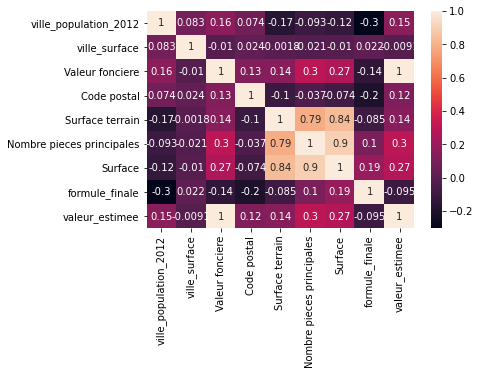

In [27]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_Donnees_immobilieres.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Calcul en régréssion linéaire

In [28]:
data = df_Donnees_immobilieres.values
X = data[:, 8:]  # all rows, no label
y = data[:, 2]  # all rows, label only
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.*,test_size=0.*, random_state=*)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [30]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
estimator = SGDRegressor()
# estimator = LinearRegression()  # LinearRegression works with sparse matrix
estimator.fit(X_train, y_train)
predicted = estimator.predict(X_train)

In [ ]:
## Valeur estimée du bien ajouté

In [32]:
import json

estimation_set = {"estimation": str(round(predicted[-1]))}
json_estimation = json.dumps(estimation_set)
print(json_estimation)

125466.25336836072


## Résultat par nuage graphique

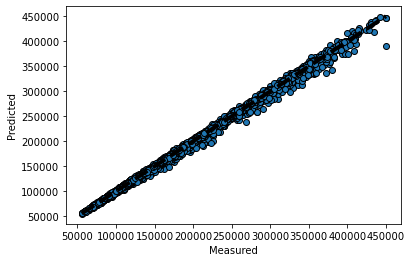

In [33]:

fig, ax = plt.subplots()
#plt.xlim(0, 200000)
#plt.ylim(0, 200000) 
ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
#ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Résultat de performances

In [34]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, y_train)

y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 3443.109602100551
le score R2 est 0.9977932003128991


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 3071.2854201047635
le score R2 est 0.9983714982617311
